In [11]:
from os.path import basename, isfile, join, splitext

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from insightface_func.face_detect_crop_single import Face_detect_crop
from models.models import create_model
from options.test_options import TestOptions

import os
import shutil
from os.path import basename, exists, isfile, join, splitext

import cv2
import numpy as np
import torch
from tqdm import tqdm

from util.videoswap import lower_resolution, extract_audio, get_frames_n, _totensor

import warnings
warnings.filterwarnings('ignore')

from face_seg.nets.MobileNetV2_unet import MobileNetV2_unet

seg_model = MobileNetV2_unet(None).to('cuda')
state_dict = torch.load('face_seg/checkpoints/model.pt', map_location='cpu')
seg_model.load_state_dict(state_dict)
seg_model.eval();

model, app = None, None
transformer_Arcface = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

opt = TestOptions()
opt.initialize()
opt.parser.add_argument('-f')  # dummy arg to avoid bug
opt = opt.parse()
opt.Arc_path = './weights/arcface_checkpoint.tar'
opt.isTrain = False
torch.nn.Module.dump_patches = True
global model
model = create_model(opt)
model.eval()
global app
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id=0, det_thresh=0.6, det_size=(256, 256))

source = '../reference_videos/gen_0.jpg'
target = '../reference_videos/stocks/man_2.mp4'
# source = 'IMG_1237.JPG'
# target = 'IMG_1222.MOV'
result_dir='./output'
crop_size=224


assert isfile(source), f'Can\'t find source at {source}'
assert isfile(target), f'Can\'t find target at {target}'
output_filename = f'infer-{splitext(basename(source))[0]}-{splitext(basename(target))[0]}.mp4'
output_path = join(result_dir, output_filename)

assert model is not None
assert app is not None

img_a_whole = cv2.imread(source)
img_a_align_crop, _ = app.get(img_a_whole, crop_size)
img_a_align_crop_pil = Image.fromarray(
    cv2.cvtColor(img_a_align_crop[0], cv2.COLOR_BGR2RGB))
img_a = transformer_Arcface(img_a_align_crop_pil)
img_id = img_a.view(-1, img_a.shape[0], img_a.shape[1], img_a.shape[2])
img_id = img_id.cuda()

img_id_downsample = F.interpolate(img_id, scale_factor=0.5)
latend_id = model.netArc(img_id_downsample)
latend_id = latend_id.detach().to('cpu')
latend_id = latend_id / np.linalg.norm(latend_id, axis=1, keepdims=True)
latend_id = latend_id.to('cuda')

------------ Options -------------
gpu_ids: [0]
isTrain: False
target_dict: {'name': 'people', 'gpu_ids': '0', 'checkpoints_dir': './checkpoints', 'model': 'pix2pixHD', 'norm': 'batch', 'use_dropout': False, 'data_type': 32, 'verbose': False, 'fp16': False, 'local_rank': 0, 'isTrain': True, 'batchSize': 8, 'loadSize': 1024, 'fineSize': 512, 'label_nc': 0, 'input_nc': 3, 'output_nc': 3, 'dataroot': './datasets/cityscapes/', 'resize_or_crop': 'scale_width', 'serial_batches': False, 'no_flip': False, 'nThreads': 2, 'max_dataset_size': inf, 'display_winsize': 512, 'tf_log': False, 'netG': 'global', 'latent_size': 512, 'ngf': 64, 'n_downsample_global': 3, 'n_blocks_global': 6, 'n_blocks_local': 3, 'n_local_enhancers': 1, 'niter_fix_global': 0, 'no_instance': False, 'instance_feat': False, 'label_feat': False, 'feat_num': 3, 'load_features': False, 'n_downsample_E': 4, 'nef': 16, 'n_clusters': 10, 'image_size': 224, 'norm_G': 'spectralspadesyncbatch3x3', 'semantic_nc': 3, 'ntest': inf, 'resu

2021-07-29 00:01:19.558675398 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,10} does not match actual shape of {128,10} for output 500
2021-07-29 00:01:19.558736397 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,4} does not match actual shape of {128,4} for output 497
2021-07-29 00:01:19.558766896 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,1} does not match actual shape of {128,1} for output 494
2021-07-29 00:01:19.559358976 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {3200,10} does not match actual shape of {512,10} for output 477
2021-07-29 00:01:19.559428274 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {3200,4} does not match actual shape of {512,4} for output 474
2021-07-29 00:01:19.559503272 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expec

In [12]:
import torchvision.transforms as transforms
from fsr.models.SRGAN_model import SRGANModel
import easydict

esrgan_fsr_transform = transforms.Compose([transforms.Resize((128, 128)),
                                 transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                      std=[0.5, 0.5, 0.5])])

args = easydict.EasyDict({
    'gpu_ids': None,
    'batch_size': 32,
    'lr_G': 1e-4,
    'weight_decay_G': 0,
    'beta1_G': 0.9,
    'beta2_G': 0.99,
    'lr_D': 1e-4,
    'weight_decay_D': 0,
    'beta1_D': 0.9,
    'beta2_D': 0.99,
    'lr_scheme': 'MultiStepLR',
    'niter': 100000,
    'warmup_iter': -1,
    'lr_steps': [50000],
    'lr_gamma': 0.5,
    'pixel_criterion': 'l1',
    'pixel_weight': 1e-2,
    'feature_criterion': 'l1',
    'feature_weight': 1,
    'gan_type': 'ragan',
    'gan_weight': 5e-3,
    'D_update_ratio': 1,
    'D_init_iters': 0,

    'print_freq': 100,
    'val_freq': 1000,
    'save_freq': 10000,
    'crop_size': 0.85,
    'lr_size': 128,
    'hr_size': 512,

    # network G
    'which_model_G': 'RRDBNet',
    'G_in_nc': 3,
    'out_nc': 3,
    'G_nf': 64,
    'nb': 16,

    # network D
    'which_model_D': 'discriminator_vgg_128',
    'D_in_nc': 3,
    'D_nf': 64,

    # data dir
    'pretrain_model_G': 'weights/90000_G.pth',
    'pretrain_model_D': None
})


esrgan_fsr_model = SRGANModel(args, is_train=False)
esrgan_fsr_model.load()
esrgan_fsr_model.netG.to('cuda')
esrgan_fsr_model.netG.eval();

Network G structure: DataParallel - RRDBNet, with parameters: 11,662,019


> Time elapsed on `Lowering resolution`: 00:00:00 (2021-07-29 00:21:45.822464).
=> Swapping face in "../reference_videos/stocks/man_2.mp4"...
=> Extracting audio from video "man_2.mp4"...
> > > > > Unable to extract audio of ../reference_videos/stocks/man_2.mp4 (2021-07-29 00:21:45.823399).
> Time elapsed on `Extracting audio`: 00:00:00 (2021-07-29 00:21:45.934692).


Output file #0 does not contain any stream
0it [00:00, ?it/s]

> Time elapsed on `Getting number of frames`: 00:00:01 (2021-07-29 00:21:47.075620).
swaped_img:


2021-07-29 00:21:47.144257358 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,10} does not match actual shape of {128,10} for output 500
2021-07-29 00:21:47.144325056 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,4} does not match actual shape of {128,4} for output 497
2021-07-29 00:21:47.144354055 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,1} does not match actual shape of {128,1} for output 494
2021-07-29 00:21:47.144974535 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {3200,10} does not match actual shape of {512,10} for output 477
2021-07-29 00:21:47.145054133 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {3200,4} does not match actual shape of {512,4} for output 474
2021-07-29 00:21:47.145113931 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expec

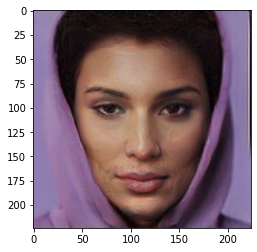

face segmentation:


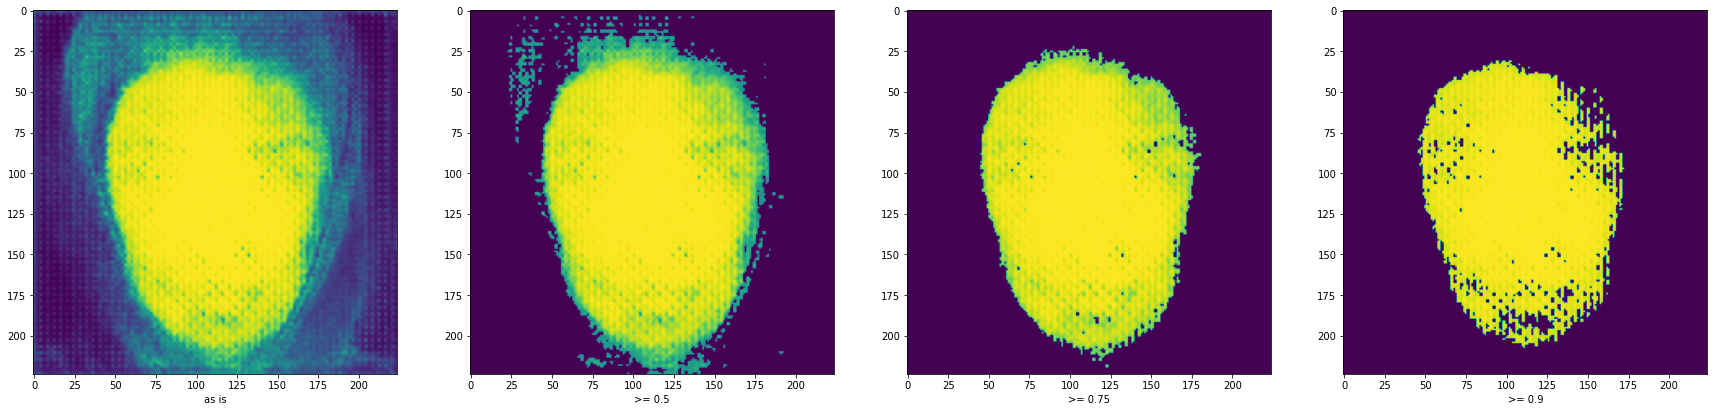

hair segmentation:


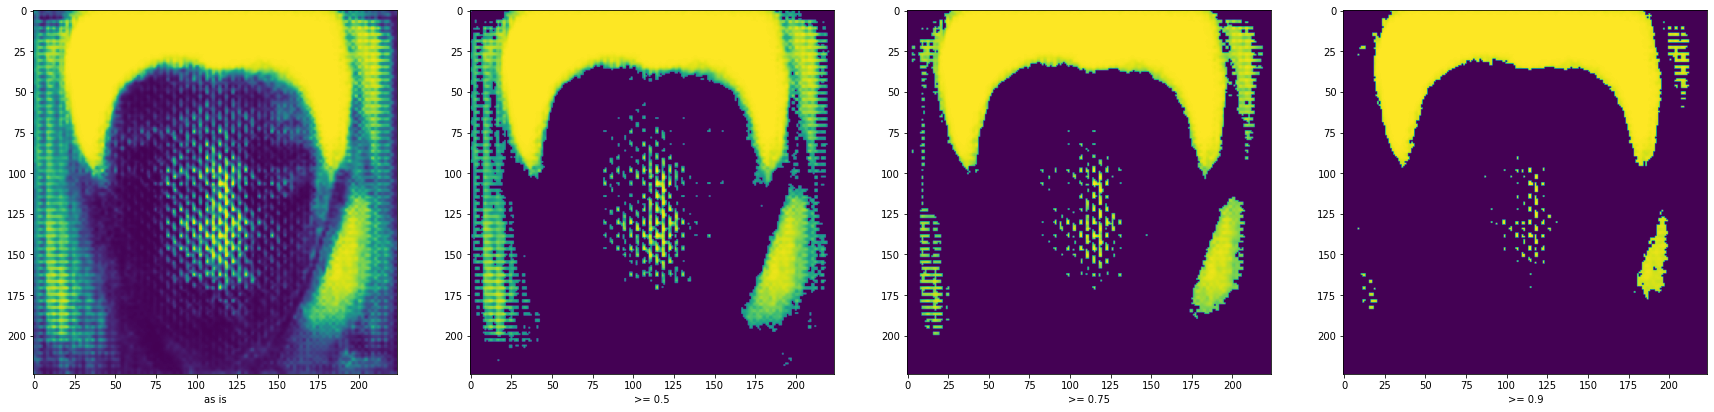

img_mask:


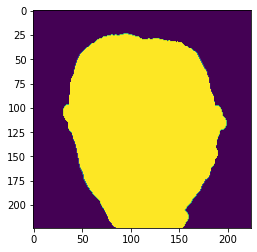

final_img-RGB:


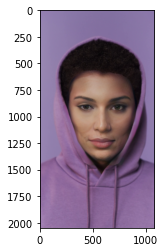

1it [00:02,  2.25s/it]


In [21]:
import matplotlib.pyplot as plt
from scipy.special import expit
from torchvision.transforms.functional import normalize


def reverse2wholeimage(swaped_imgs, mats, crop_size, oriimg, save_path=''):
    target_image_list = []
    img_mask_list = []
    for swaped_img, mat in zip(swaped_imgs, mats):
        print('swaped_img:'); plt.imshow(swaped_img.cpu().detach().numpy().transpose((1, 2, 0))); plt.show() ###        
        
        # https://github.com/kampta/face-seg
        seg_mask_logits = seg_model(swaped_img.unsqueeze(0))
        seg_mask = seg_mask_logits.squeeze().cpu().detach().numpy().transpose((1, 2, 0))
        img_mask = np.argmax(seg_mask, axis=2) == 1
        img_mask = np.array(img_mask * 255, dtype=float)
        # img_mask = np.full((crop_size, crop_size), 255, dtype=float)

        # select and fill the biggest contour
        contours, _ = cv2.findContours(img_mask.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        img_mask_ = np.zeros_like(img_mask)
        cv2.drawContours(img_mask_, [max(contours, key = cv2.contourArea)], 0, 255, -1)
        img_mask = np.array(img_mask_)
        
        ###
        print('face segmentation:')
        sigm_ = expit(seg_mask[:, :, 1])
        fig, axs = plt.subplots(1, 4, figsize=(30, 30))
        axs.flat[0].imshow(sigm_); axs.flat[0].set_xlabel('as is')
        sigm_[sigm_ < 0.5] = 0; axs.flat[1].imshow(sigm_); axs.flat[1].set_xlabel('>= 0.5')
        sigm_[sigm_ < 0.75] = 0; axs.flat[2].imshow(sigm_); axs.flat[2].set_xlabel('>= 0.75')
        sigm_[sigm_ < 0.9] = 0; axs.flat[3].imshow(sigm_); axs.flat[3].set_xlabel('>= 0.9')
        plt.show()
        ###
    
        ###
        print('hair segmentation:')
        sigm_ = expit(seg_mask[:, :, 2])
        fig, axs = plt.subplots(1, 4, figsize=(30, 30))
        axs.flat[0].imshow(sigm_); axs.flat[0].set_xlabel('as is')
        sigm_[sigm_ < 0.5] = 0; axs.flat[1].imshow(sigm_); axs.flat[1].set_xlabel('>= 0.5')
        sigm_[sigm_ < 0.75] = 0; axs.flat[2].imshow(sigm_); axs.flat[2].set_xlabel('>= 0.75')
        sigm_[sigm_ < 0.9] = 0; axs.flat[3].imshow(sigm_); axs.flat[3].set_xlabel('>= 0.9')
        plt.show()
        ###


        # SR-ESRGAN_fsr https://github.com/ewrfcas/Face-Super-Resolution
        swaped_img = esrgan_fsr_transform(torch.clone(swaped_img))
        swaped_img = esrgan_fsr_model.netG(swaped_img.unsqueeze(0))
        swaped_img = swaped_img.squeeze(0).cpu().detach().numpy().transpose((1, 2, 0))
        swaped_img = np.clip(swaped_img / 2.0 + 0.5, 0, 1)

        # cv2.imwrite(splitext(save_path)[0] + '_' + splitext(save_path)[1], cv2.cvtColor(swaped_img * 255, cv2.COLOR_BGR2RGB))

        mat_rev = cv2.invertAffineTransform(mat)
        mat_rev_face = np.array(mat_rev)
        mat_rev_face[:2, :2] = mat_rev_face[:2, :2] / (swaped_img.shape[0] / crop_size)

        orisize = (oriimg.shape[1], oriimg.shape[0])
        target_image = cv2.warpAffine(swaped_img, mat_rev_face, orisize)
        img_mask = cv2.warpAffine(img_mask, mat_rev, orisize)

        # ###
        # print('Erode parameters:')
        # fig, axs = plt.subplots(1, 5, figsize=(30, 30))
        # img_mask_ = np.array(img_mask)
        # axs.flat[0].imshow(img_mask_[500:1500]); axs.flat[0].set_xlabel('as is')
        # img_mask_ = np.array(img_mask); img_mask_[img_mask_ > 1] = 255
        # axs.flat[1].imshow(img_mask_[500:1500]); axs.flat[1].set_xlabel('> 1')
        # img_mask_ = np.array(img_mask); img_mask_[img_mask_ > 5] = 255
        # axs.flat[2].imshow(img_mask_[500:1500]); axs.flat[2].set_xlabel('> 5')
        # img_mask_ = np.array(img_mask); img_mask_[img_mask_ > 10] = 255
        # axs.flat[3].imshow(img_mask_[500:1500]); axs.flat[3].set_xlabel('> 10')
        # img_mask_ = np.array(img_mask); img_mask_[img_mask_ > 20] = 255
        # axs.flat[4].imshow(img_mask_[500:1500]); axs.flat[4].set_xlabel('> 20')
        # plt.show()
        # ###

        # fig, axs = plt.subplots(1, 2, figsize=(30, 30))
        # axs.flat[0].imshow(img_mask); axs.flat[0].set_xlabel('as is')
        # contours, _ = cv2.findContours(img_mask.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        # img_mask_ = np.zeros_like(img_mask)
        # cv2.drawContours(img_mask_, [max(contours, key = cv2.contourArea)], 0, 255, -1)
        # img_mask = np.array(img_mask_)
        # axs.flat[1].imshow(img_mask); axs.flat[1].set_xlabel('bigget filled contour')
        # plt.show()

        # ###
        # fig, axs = plt.subplots(3, 5, figsize=(50, 30)); 
        # img_mask_ = np.array(img_mask) / 255;
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][0].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][0].set_xlabel('as is')

        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((10, 10), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=1) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][1].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][1].set_xlabel('k10x10_1')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((10, 10), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=2) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[1][1].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[1][1].set_xlabel('k10x10_2')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((10, 10), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=3) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[2][1].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[2][1].set_xlabel('k10x10_3')


        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((15, 15), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=1) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][2].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][2].set_xlabel('k15x15')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((15, 15), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=2) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[1][2].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[1][2].set_xlabel('k15x15_2')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((15, 15), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=3) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[2][2].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[2][2].set_xlabel('k15x15_3')


        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((20, 20), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=1) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][3].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][3].set_xlabel('k20x20')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((20, 20), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=2) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[1][3].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[1][3].set_xlabel('k20x20_2')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((20, 20), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=3) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[2][3].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[2][3].set_xlabel('k20x20_3')


        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((30, 30), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=1) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][4].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][4].set_xlabel('k30x30')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((30, 30), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=2) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[1][4].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[1][4].set_xlabel('k30x30_2')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((30, 30), np.uint8)
        # img_mask_ = cv2.erode(img_mask_, kernel, iterations=3) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[2][4].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[2][4].set_xlabel('k30x30_3')

        # plt.show()
        # ###

        # ###
        # print('Dilation parameters:')
        # fig, axs = plt.subplots(3, 5, figsize=(50, 30)); 
        # img_mask_ = np.array(img_mask) / 255;
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][0].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][0].set_xlabel('as is')

        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((10, 10), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=1) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][1].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][1].set_xlabel('k10x10_1')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((10, 10), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=2) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[1][1].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[1][1].set_xlabel('k10x10_2')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((10, 10), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=3) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[2][1].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[2][1].set_xlabel('k10x10_3')


        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((15, 15), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=1) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][2].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][2].set_xlabel('k15x15')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((15, 15), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=2) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[1][2].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[1][2].set_xlabel('k15x15_2')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((15, 15), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=3) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[2][2].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[2][2].set_xlabel('k15x15_3')


        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((20, 20), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=1) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][3].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][3].set_xlabel('k20x20')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((20, 20), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=2) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[1][3].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[1][3].set_xlabel('k20x20_2')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((20, 20), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=3) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[2][3].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[2][3].set_xlabel('k20x20_3')


        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((30, 30), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=1) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[0][4].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[0][4].set_xlabel('k30x30')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((30, 30), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=2) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[1][4].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[1][4].set_xlabel('k30x30_2')
        # img_mask_ = np.array(img_mask);
        # kernel = np.ones((30, 30), np.uint8)
        # img_mask_ = cv2.dilate(img_mask_, kernel, iterations=3) / 255
        # img_mask_ = np.reshape(img_mask_, [img_mask_.shape[0], img_mask_.shape[1], 1])
        # target_image_ = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        # img = img_mask_ * target_image_ + (1-img_mask_) * np.array(oriimg, dtype=np.float64)
        # axs[2][4].imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)[500:1500]); axs[2][4].set_xlabel('k30x30_3')

        # plt.show()
        # ###


        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)) # np.ones((10, 10), np.uint8)
        img_mask = cv2.dilate(img_mask, kernel, iterations=3) / 255
        print('img_mask:'); plt.imshow(img_mask); plt.show() ###
        # print('img_mask + MORPH_OPEN:'); plt.imshow(cv2.morphologyEx(img_mask, cv2.MORPH_OPEN, kernel)); plt.show() ###
        # print('img_mask + MORPH_CLOSE:'); plt.imshow(cv2.morphologyEx(img_mask, cv2.MORPH_CLOSE, kernel)); plt.show() ###
        img_mask = np.reshape(img_mask, [img_mask.shape[0], img_mask.shape[1], 1])
        target_image = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        img_mask_list.append(img_mask)
        target_image_list.append(target_image)

    img = np.array(oriimg, dtype=np.float64)
    for img_mask, target_image in zip(img_mask_list, target_image_list):
        img = img_mask * target_image + (1-img_mask) * img

    final_img = img.astype(np.uint8)
    print('final_img-RGB:'); plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)); plt.show() ###

    cv2.imwrite(save_path, final_img)


video_path = target
temp_results_dir='./temp_results'
swap_model = model
detect_model = app
id_veсtor = latend_id

lower_resolution(video_path)
print(f'=> Swapping face in "{video_path}"...')
if exists(temp_results_dir):
    shutil.rmtree(temp_results_dir)
os.makedirs(temp_results_dir)

audio_path = join(temp_results_dir, splitext(basename(video_path))[0] + '.wav')
extract_audio(video_path, audio_path)

frame_count = get_frames_n(video_path)

video = cv2.VideoCapture(video_path)
fps = video.get(cv2.CAP_PROP_FPS)

for i, frame_index in tqdm(enumerate(range(frame_count))): 
    if i != 0:
        break
    _, frame = video.read()
    detect_results = detect_model.get(frame, crop_size)     

    if detect_results is not None:
        frame_align_crop_list = detect_results[0]
        frame_mat_list = detect_results[1]
        swap_result_list = []

        for frame_align_crop in frame_align_crop_list:
            frame_align_crop_tensor = _totensor(cv2.cvtColor(frame_align_crop,cv2.COLOR_BGR2RGB))[None,...].cuda()

            swap_result = swap_model(None, frame_align_crop_tensor, id_veсtor, None, True)[0]
            swap_result_list.append(swap_result)
        reverse2wholeimage(swap_result_list, frame_mat_list, crop_size, frame, join(temp_results_dir, 'frame_{:0>7d}.jpg'.format(frame_index)))
    else:
        frame = frame.astype(np.uint8)
        cv2.imwrite(join(temp_results_dir, 'frame_{:0>7d}.jpg'.format(frame_index)), frame)